# Dataexploration Project (Mehmet Karaca)

Das Projekt ist unter folgendem Link auf GitHub verfügbar: [https://github.com/Mehmet1700/DataExplorationProject]
Bitte das Jupyter Notebook `DataExplorationProject.ipynb` öffnen, um den Code und die Dokumentation zu sehen.

## Problem
Wir haben einen Datensatz zu Gehirntumoren mit den dazugehörigen Bildern. Wir möchten ein Modell entwickeln, das die Bilder analysiert und die Tumore erkennt. Anwendungsgebiet ist beispielsweise die Medizin, um die Diagnose von Gehirntumoren zu unterstützen.

## Daten
Die Daten stammen aus Kaggle(https://www.kaggle.com/datasets/jakeshbohaju/brain-tumor/data?select=Brain+Tumor.csv). Der Datensatz enthält eine Vielzahl von Features, allerdings sind für uns nur die Zuordnung zu den Bildern und die Class (Tumor oder kein Tumor) relevant. Der Grund ist, dass wir unser Modell auf den Bildern trainieren und testen möchten und die anderen Features nicht benötigt werden. Die Bilder sind in einem separaten Ordner abgelegt. 

## Lösung
Wir werden ein Modell entwickeln, das die Bilder analysiert und die Tumore erkennt. Dazu werden wir ein Convolutional Neural Network (CNN) verwenden. CNNs sind speziell für die Verarbeitung von Bildern geeignet. Wir werden das Modell auf den Trainingsdaten trainieren und auf den Testdaten testen. Anschließend werden wir die Performance des Modells evaluieren.

## Software
Wir werden Python und die Bibliotheken pandas, numpy, matplotlib und tensorflow verwenden. Als ML Lifecycle Framework verwenden wir MLflow, da es uns ermöglicht, den gesamten ML Lifecycle zu verwalten und Open Source ist.


## Laden der Bibliotheken

In [1]:
import os
import pandas as pd
import numpy as np
import random
from shutil import copyfile
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score , precision_score , recall_score , f1_score , confusion_matrix
from sklearn.dummy import DummyClassifier
from random import uniform, choice
import mlflow
from mlflow import log_metric, log_param
from mlflow.models import infer_signature
import subprocess


## Einlesen der CSV Datei und Anzeige der ersten 5 Zeilen und weitere Analysen

In [2]:
# Path to the CSV file
csv_file = "brain-tumor/Brain_Tumor.csv"

# Load the Image and Class columns from the CSV file to reduce the number of data records per class.
# Only the Image and Class columns are loaded, as the other columns are not relevant for the analysis. 
data = pd.read_csv(csv_file)[['Image', 'Class']] 

# Check the first lines of the data set
print("Erste Zeilen des Datensatzes:")
print(data.head())

# Check the number of missing values in each feature
print("\nAnzahl der fehlenden Werte pro Feature:")
print(data.isnull().sum())

# Check the total number of data records
print("\nGesamtanzahl der Datensätze:", len(data))

Erste Zeilen des Datensatzes:
    Image  Class
0  Image1      0
1  Image2      0
2  Image3      1
3  Image4      1
4  Image5      0

Anzahl der fehlenden Werte pro Feature:
Image    0
Class    0
dtype: int64

Gesamtanzahl der Datensätze: 3762


## Klassenverteilung überprüfen

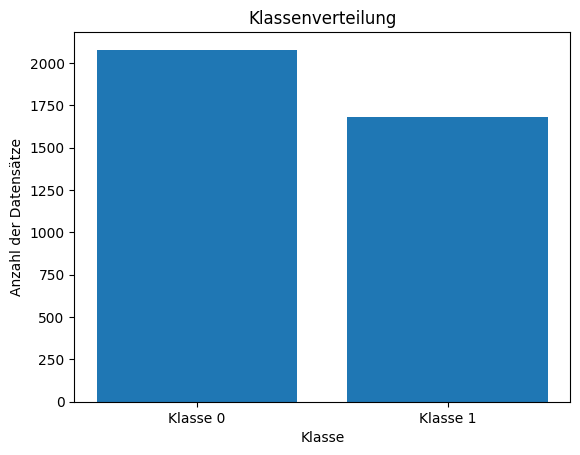

In [3]:
# Check class distribution
class_distribution = data['Class'].value_counts()

# Create a bar chart of the class distribution
plt.bar(class_distribution.index, class_distribution.values)

# Add labels and titles
plt.xlabel('Klasse')
plt.ylabel('Anzahl der Datensätze')
plt.title('Klassenverteilung')

# Label class 0 and 1 accordingly
plt.xticks([0, 1], ['Klasse 0', 'Klasse 1'])

# Show diagram
plt.show()


In [4]:
# Statistical summary
stat_summary = data.describe()
print("Statistische Zusammenfassung:")
print(stat_summary)


Statistische Zusammenfassung:
             Class
count  3762.000000
mean      0.447368
std       0.497288
min       0.000000
25%       0.000000
50%       0.000000
75%       1.000000
max       1.000000


## Erster Eindruck der Daten
Wie man an den Daten und Grafiken erkennen kann, sind die Daten sauber und es gibt keine fehlenden Werte. Die Klassenverteilung ist auch relativ ausgeglichen, allerdings gibt es mehr Bilder ohne Tumor als mit Tumor. Dennoch werden wir die Klassenverteilung verbessern, um ein besseres Modell zu erhalten.

## Daten vorbereiten
Wir werden die Daten vorbereiten, indem wir die Bilder laden und die Klassenverteilung anpassen. Dazu werden wir die Daten in Trainings-, Validierungs- und Testdaten aufteilen. Die Bilder werden in ein Array umgewandelt und normalisiert. Die Klassenverteilung wird angepasst, indem wir die Anzahl der Bilder mit Tumor erhöhen aber auch die Form anpassen. Die Schritte heißen Data Augmentation und Data Balancing (oversampling / undersampling).

In [5]:
# Random data shuffle function
def split_size(df, size):
    return int(size * len(df))

#Training data (80% of the data for the training)
train_labels = data['Class'].values[:split_size(data, 0.8)]
train_images = data['Image'].values[:split_size(data, 0.8)]

#Validierungsdaten (10% der Daten für die Validierung)
val_labels = data['Class'].values[split_size(data, 0.8):split_size(data, 0.9)]
val_images = data['Image'].values[split_size(data, 0.8):split_size(data, 0.9)]
#Es werden die Daten von 80% bis 90% für die Validierung verwendet.

#Validation data (10% of the data for validation)
test_labels = data['Class'].values[split_size(data, 0.9):]
test_images = data['Image'].values[split_size(data, 0.9):]
#The data from 90% to 100% is used for testing.


Größe der Trainingsdaten: 3009
Größe der Validierungsdaten: 376
Größe der Testdaten: 377
Erste 5 Trainingsdaten:
[0 0 1 1 0]
['Image1' 'Image2' 'Image3' 'Image4' 'Image5']

Erste 5 Validierungsdaten:
[1 1 1 1 1]
['Image3010' 'Image3011' 'Image3012' 'Image3013' 'Image3014']

Erste 5 Testdaten:
[1 1 1 1 1]
['Image3386' 'Image3387' 'Image3388' 'Image3389' 'Image3390']


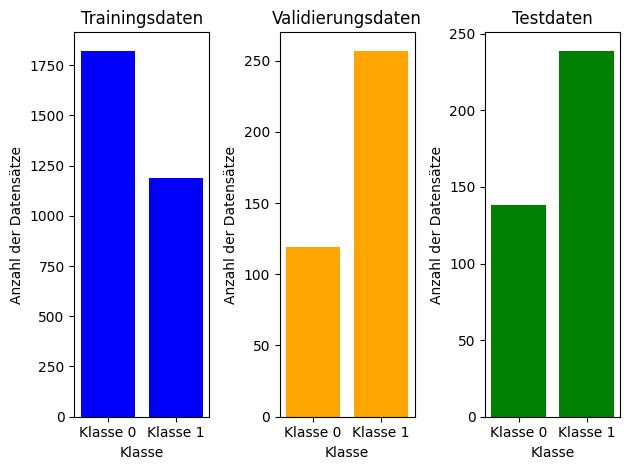

In [6]:
# Check the size of the training, validation and test data
print("Größe der Trainingsdaten:", len(train_labels))
print("Größe der Validierungsdaten:", len(val_labels))
print("Größe der Testdaten:", len(test_labels))

#Output of the first 5 training data
print("Erste 5 Trainingsdaten:")
print(train_labels[:5])
print(train_images[:5])

#Output the first 5 validation data
print("\nErste 5 Validierungsdaten:")
print(val_labels[:5])
print(val_images[:5])

#Output of the first 5 test data
print("\nErste 5 Testdaten:")
print(test_labels[:5])
print(test_images[:5])

# Class distribution in the training data
train_class_distribution = np.unique(train_labels, return_counts=True)
plt.subplot(1, 3, 1)
plt.bar(train_class_distribution[0], train_class_distribution[1], color='blue')
plt.xlabel('Klasse')
plt.ylabel('Anzahl der Datensätze')
plt.title('Trainingsdaten')
plt.xticks([0, 1], ['Klasse 0', 'Klasse 1'])

# Class distribution in the validation data
val_class_distribution = np.unique(val_labels, return_counts=True)
plt.subplot(1, 3, 2)
plt.bar(val_class_distribution[0], val_class_distribution[1], color='orange')
plt.xlabel('Klasse')
plt.ylabel('Anzahl der Datensätze')
plt.title('Validierungsdaten')
plt.xticks([0, 1], ['Klasse 0', 'Klasse 1'])

# Class distribution in the test data
test_class_distribution = np.unique(test_labels, return_counts=True)
plt.subplot(1, 3, 3)
plt.bar(test_class_distribution[0], test_class_distribution[1], color='green')
plt.xlabel('Klasse')
plt.ylabel('Anzahl der Datensätze')
plt.title('Testdaten')
plt.xticks([0, 1], ['Klasse 0', 'Klasse 1'])

plt.tight_layout()
plt.show()



In [7]:
# Function for assigning the images to the classes
def split_data(image, label):
    #If the class is 0, the image is copied to the folder "0"
    arr_image_0 = image[np.where(label==0)]
    #If the class is 1, the image is copied to folder "1"
    arr_image_1 = image[np.where(label==1)]
    #Return of the images in folders "0" and "1"
    return {'0':arr_image_0, '1':arr_image_1}

In [8]:
#Create a dictionary containing the images in folders "0" and "1"
train_data = split_data(train_images, train_labels)
val_data = split_data(val_images, val_labels)
test_data = split_data(test_images, test_labels)

# Check the number of images in the folders "0" and "1" in the training data
print("Anzahl der Bilder in den Trainingsdaten:")
print("Klasse 0:", len(train_data['0']))
print("Klasse 1:", len(train_data['1']))
print("Gesamtanzahl der Bilder:", len(train_data['0']) + len(train_data['1']))


# Check the number of images in the folders "0" and "1" in the validation data
print("\nAnzahl der Bilder in den Validierungsdaten:")
print("Klasse 0:", len(val_data['0']))
print("Klasse 1:", len(val_data['1']))
print("Gesamtanzahl der Bilder:", len(val_data['0']) + len(val_data['1']))

# Check the number of images in the folders "0" and "1" in the test data
print("\nAnzahl der Bilder in den Testdaten:")
print("Klasse 0:", len(test_data['0']))
print("Klasse 1:", len(test_data['1']))
print("Gesamtanzahl der Bilder:", len(test_data['0']) + len(test_data['1']))

#We have split the data and now have a dictionary containing the images in folders "0" and "1".

Anzahl der Bilder in den Trainingsdaten:
Klasse 0: 1822
Klasse 1: 1187
Gesamtanzahl der Bilder: 3009

Anzahl der Bilder in den Validierungsdaten:
Klasse 0: 119
Klasse 1: 257
Gesamtanzahl der Bilder: 376

Anzahl der Bilder in den Testdaten:
Klasse 0: 138
Klasse 1: 239
Gesamtanzahl der Bilder: 377


## Verknüpfung der Bildnamen mit den Pfaden
Im vorherigen Schritt hatten wir nur die Bildnamen aufgeteilt, allerdings benötigen wir die vollständigen Pfade zu den Bildern. Dazu werden wir die Bildnamen mit den Pfaden zu den Bildern verknüpfen. Diese werden in die entsprechenden Ordner aufgeteilt. Außerdem werden wir das Format der Bilder überprüfen, um sicherzustellen, dass alle Bilder das gleiche Format haben.

In [9]:
#Analyze the images in BrainTumorPics for the number of pixels and color channels
#Create a list to store the number of pixels and color channels for each image
image_data = []
#Path to the folder with the images
image_folder = "brain-tumor/BrainTumorPics"
#List of files in the folder
image_files = os.listdir(image_folder)
#For each image in the folder
for file in image_files:
    #Path to the image
    image_path = os.path.join(image_folder, file)
    #Open the image
    img = image.load_img(image_path)
    #Convert the image into a numpy array
    img_array = image.img_to_array(img)
    #Add the number of pixels and color channels to the image_size array
    image_data.append(img_array.shape)

#Check image_size for the number of pixels for each image without duplicate values
unique_image_data = np.unique(image_data, axis=0)
print("Anzahl der Pixel und Farbkanäle für jedes Bild:")
print(unique_image_data)



Anzahl der Pixel und Farbkanäle für jedes Bild:
[[240 240   3]]


In [10]:
#Function for creating folders train,val and test with respective subfolders 0 and 1
def create_directories(data, directory):
    #Create the main folder
    os.makedirs(directory, exist_ok=True)
    #Create the subfolder "0"
    os.makedirs(directory + '/0', exist_ok=True)
    #Create the subfolder "1"
    os.makedirs(directory + '/1', exist_ok=True)
    #Copy the images into the subfolder "0"
    for image in data['0']:
        copyfile('brain-tumor/BrainTumorPics/' + image + '.jpg', directory + '/0/' + '/' + image + '.jpg')
    #Copy the images into the subfolder "1"
    for image in data['1']:
        copyfile('brain-tumor/BrainTumorPics/' + image + '.jpg', directory + '/1/' + '/' + image + '.jpg')

#Create the folders train, val and test with respective subfolders 0 and 1
create_directories(train_data, 'brain-tumor/model/train')
create_directories(val_data, 'brain-tumor/model/val')
create_directories(test_data, 'brain-tumor/model/test')


In [11]:
#Check the number of images per folder
print("Anzahl der Bilder pro Ordner:")
print("Trainingsdaten:")
print("Klasse 0:", len(os.listdir('brain-tumor/model/train/0')))
print("Klasse 1:", len(os.listdir('brain-tumor/model/train/1')))
print("Validierungsdaten:")
print("Klasse 0:", len(os.listdir('brain-tumor/model/val/0')))
print("Klasse 1:", len(os.listdir('brain-tumor/model/val/1')))
print("Testdaten:")
print("Klasse 0:", len(os.listdir('brain-tumor/model/test/0')))
print("Klasse 1:", len(os.listdir('brain-tumor/model/test/1')))


Anzahl der Bilder pro Ordner:
Trainingsdaten:
Klasse 0: 1822
Klasse 1: 1822
Validierungsdaten:
Klasse 0: 119
Klasse 1: 257
Testdaten:
Klasse 0: 138
Klasse 1: 239


## Anzeigen einer zufälligen Auswahl von Bildern

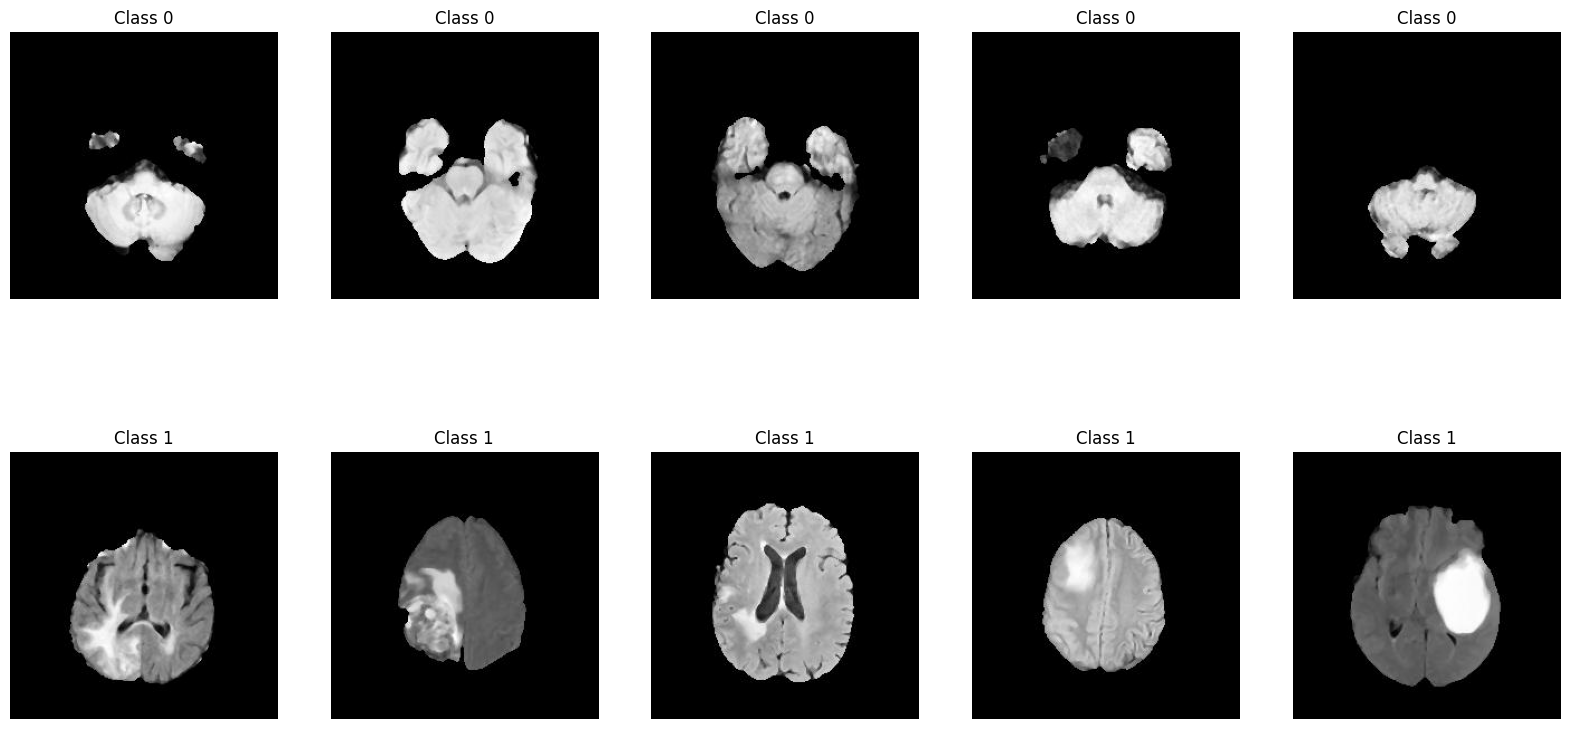

In [12]:
# Display the first 5 images from the training folder "0" and "1"
# Create a 2x5 raster graphic (10 images in total)
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
axes = axes.flatten() # Flatten the array of axes for easy access

# Loop runs through each index of the axes
for i, ax in enumerate(axes):
    if i < 5: # The first 5 images are of class 0
        # Create image path for class 0 and load image
        img = mpimg.imread('brain-tumor/model/train/0/' + os.listdir('brain-tumor/model/train/0')[i])
        ax.imshow(img) # Show image on the axis
        ax.set_title('Class 0') # Set the title of the axis to 'Class 0'
    else:
        # The next 5 images are from class 1
        # Create image path for class 1 and load image
        img = mpimg.imread('brain-tumor/model/train/1/' + os.listdir('brain-tumor/model/train/1')[i-5])
        ax.imshow(img) # Show image on the axis
        ax.set_title('Class 1') # Set the title of the axis to 'Class 1'
    ax.axis('off') # Deactivate axis labels to display only the images

## Data Balancing
Im nächsten Schritt wird Oversampling durchgeführt, um die Klassenverteilung anzupassen. Dazu werden wir die Anzahl der Bilder mit Tumor erhöhen für den Trainingsdatensatz. Für den Validierungs- und Testdatensatz wird keine Anpassung vorgenommen, da wir die Performance des Modells auf unveränderten Daten testen möchten. Die Klasse ohne Tumor hat 1822 Bilder und die Klasse mit Tumor hat 1187 Bilder. Wir werden die Anzahl der Bilder mit Tumor auf 1822 erhöhen.

In [13]:
# Oversampling of the training data
# Number of images in class 0 and class 1
num_images_class_0 = len(os.listdir('brain-tumor/model/train/0'))
num_images_class_1 = len(os.listdir('brain-tumor/model/train/1'))

# Number of images to be added to class 0 and class 1
num_images_to_add = num_images_class_0 - num_images_class_1

# Random selection of num_images_to_add images from class 1
images_to_add = random.sample(os.listdir('brain-tumor/model/train/1'), num_images_to_add)

# Copy the selected images to folder "1" in the training data
for image in images_to_add:
    copyfile('brain-tumor/model/train/1/' + image, 'brain-tumor/model/train/1/' + 'copy_' + image)

# Check the number of images in class 0 and class 1 after oversampling
print("Anzahl der Bilder in Klasse 0 nach dem Oversampling:", len(os.listdir('brain-tumor/model/train/0')))
print("Anzahl der Bilder in Klasse 1 nach dem Oversampling:", len(os.listdir('brain-tumor/model/train/1')))
print("Gesamtanzahl der Bilder nach dem Oversampling:", len(os.listdir('brain-tumor/model/train/0')) + len(os.listdir('brain-tumor/model/train/1')))
#The number of images in class 0 and class 1 is now the same, which means that the training data is now balanced.


Anzahl der Bilder in Klasse 0 nach dem Oversampling: 1822
Anzahl der Bilder in Klasse 1 nach dem Oversampling: 1822
Gesamtanzahl der Bilder nach dem Oversampling: 3644


## Data Augmentation 
Im nächsten schritt wird Datenaugmentierung durchgeführt, um die Anzahl der Bilder zu erhöhen und das Modell zu trainieren. Overfitting zu vermeiden und die Leistung des Modells zu verbessern. Die Bilder werden gedreht, verschoben, gezoomt und horizontal gespiegelt.

In [14]:
#Function for creating an ImageDataGenerator 
def create_data_generator(preprocessing_function=None):
    #Create the ImageDataGenerator
    datagen = ImageDataGenerator(
        #Normalize the pixel values to the range from 0 to 1
        #because the values of the pixels are between 0 and 255 and we want to normalize them to the range from 0 to 1
        rescale=1./255,
        #Random rotation of the images by 20 degrees
        rotation_range=20,
        #Random shift of the images by 0.2
        width_shift_range=0.2,
        #Random shifting of the images
        height_shift_range=0.2,
        #Random mirroring of the images
        horizontal_flip=True,
        #Random scaling of the images
        zoom_range=0.2,
        #Random brightness of the images
        brightness_range=[0.2, 1.0],
        #Function for preprocessing the images
        preprocessing_function=preprocessing_function
    )
    return datagen

#Create the ImageDataGenerator for training and validation
train_datagen = create_data_generator()
val_datagen = create_data_generator()   


#Function for loading the images from folders "0" and "1" and creating batches
def create_data_batches(datagen, directory, batch_size):
    #Create a generator for the batches
    data_batches = datagen.flow_from_directory(
    #Path to the folder with the images
    directory,        
    #target size of the images (256x256)
    target_size=(240, 240),
    #size of the batches
    batch_size=batch_size,
    #class of the mode
    class_mode='binary'
    )
    return data_batches

#Create the batches for training
train_batches = create_data_batches(train_datagen, 'brain-tumor/model/train/', 32)

#Create the batches for validation
val_batches = create_data_batches(val_datagen, 'brain-tumor/model/val/', 32)

Found 3644 images belonging to 2 classes.
Found 376 images belonging to 2 classes.


In [15]:
#Display the number of batches
print("Anzahl der Trainingsbatches:", len(train_batches))
print("Anzahl der Validierungsbatches:", len(val_batches))

Anzahl der Trainingsbatches: 114
Anzahl der Validierungsbatches: 12


## Data Training
Trainieren des Modells mit den Trainingsdaten und Validierungsdaten. Als Modell verwenden wir ein Convolutional Neural Network (CNN). Das Modell wird auf den Trainingsdaten trainiert und auf den Validierungsdaten getestet. Die Performance des Modells wird anhand der Genauigkeit und des Verlustes bewertet. Das Modell ist MobileNetV2, das auf den Bildern trainiert wird. MobileNetV2 ist ein vortrainiertes Modell, das speziell für mobile Geräte entwickelt wurde. Es ist leichtgewichtig und hat eine hohe Genauigkeit. Bei der Recherche wurde dieses Modell empfhohlen. Außerdem wurden mehrere Modelle getestet und MobileNetV2 hat die beste Performance erzielt nach nur wenigen Epochen.

In [16]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(240, 240, 3), include_top=False, weights='imagenet')

#Freeze the weights of the base model
base_model.trainable = False

last_output = base_model.output
num_trainable_params = sum([w.shape.num_elements() for w in base_model.trainable_weights])

print("Anzahl der trainierbaren Parameter:", num_trainable_params)
print("Das vortrainierte Modell hat den Typ: ", type(base_model))


Anzahl der trainierbaren Parameter: 0
Das vortrainierte Modell hat den Typ:  <class 'keras.src.engine.functional.Functional'>


## Bauen des Neuronalen Netzes (Convolutional Neural Network) 

In [17]:
# Function for transfer learning with customizable dense units and dropout rate
def transfer_learning(last_output, pre_trained_model, dense_units, dropout_rate):
    # Add a global average pooling layer
    x = layers.GlobalAveragePooling2D()(last_output)
    # Add a Dense Layer with customizable number of neurons
    x = layers.Dense(dense_units, activation='relu')(x)
    # Add a dropout layer with customizable dropout rate
    x = layers.Dropout(dropout_rate)(x)
    # Add a dense layer with 1 neuron and activation function sigmoid
    x = layers.Dense(1, activation='sigmoid')(x)
    
    # Create the model
    model = keras.Model(pre_trained_model.input, x)
    return model

In [18]:
model = transfer_learning(last_output, base_model, 512, 0.5)

#The number of trainable variables is 4, as we only train the weights of the last dense layer.
print(f"Total Trainable Variables: {len(model.trainable_variables)}")


# Compile the model. The compile function is used to configure the model and define the loss function, the optimizer and the metrics.
# Optimizer: Adam (Adaptive Moment Estimation) is an optimizer that adapts the learning rate.
# Loss function: Binary cross entropy is used as it is a binary classification problem.
# Metrics: Accuracy is used to evaluate the performance of the model.
model.compile(optimizer= tf.keras.optimizers.legacy.Adam(learning_rate=0.0001/10),
              loss='binary_crossentropy',
              metrics=['accuracy'])

#Now we have created the model and can train it with our data
#We need a callback function to stop the training when the accuracy stops increasing.
#The EarlyStopping function is used to stop the training when the accuracy stops increasing.
#The patience is set to 3, which means that the training is stopped when the accuracy stops increasing for 3 epochs.
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

Total Trainable Variables: 4


## Modell trainieren und validieren 

Epoch 1/10
114/114 [==============================] - 42s 364ms/step - loss: 0.4926 - accuracy: 0.7667 - val_loss: 0.4622 - val_accuracy: 0.8191
Epoch 2/10
114/114 [==============================] - 45s 395ms/step - loss: 0.4666 - accuracy: 0.7873 - val_loss: 0.4165 - val_accuracy: 0.8218
Epoch 3/10
114/114 [==============================] - 50s 438ms/step - loss: 0.4410 - accuracy: 0.8038 - val_loss: 0.4293 - val_accuracy: 0.8298
Epoch 4/10
114/114 [==============================] - 53s 459ms/step - loss: 0.4295 - accuracy: 0.7991 - val_loss: 0.3893 - val_accuracy: 0.8431
Epoch 5/10
114/114 [==============================] - 46s 403ms/step - loss: 0.4171 - accuracy: 0.8164 - val_loss: 0.4039 - val_accuracy: 0.8245
Epoch 6/10
114/114 [==============================] - 48s 416ms/step - loss: 0.4012 - accuracy: 0.8249 - val_loss: 0.3938 - val_accuracy: 0.8404
Epoch 7/10
114/114 [==============================] - 48s 419ms/step - loss: 0.3805 - accuracy: 0.8367 - val_loss: 0.3773 - val_ac

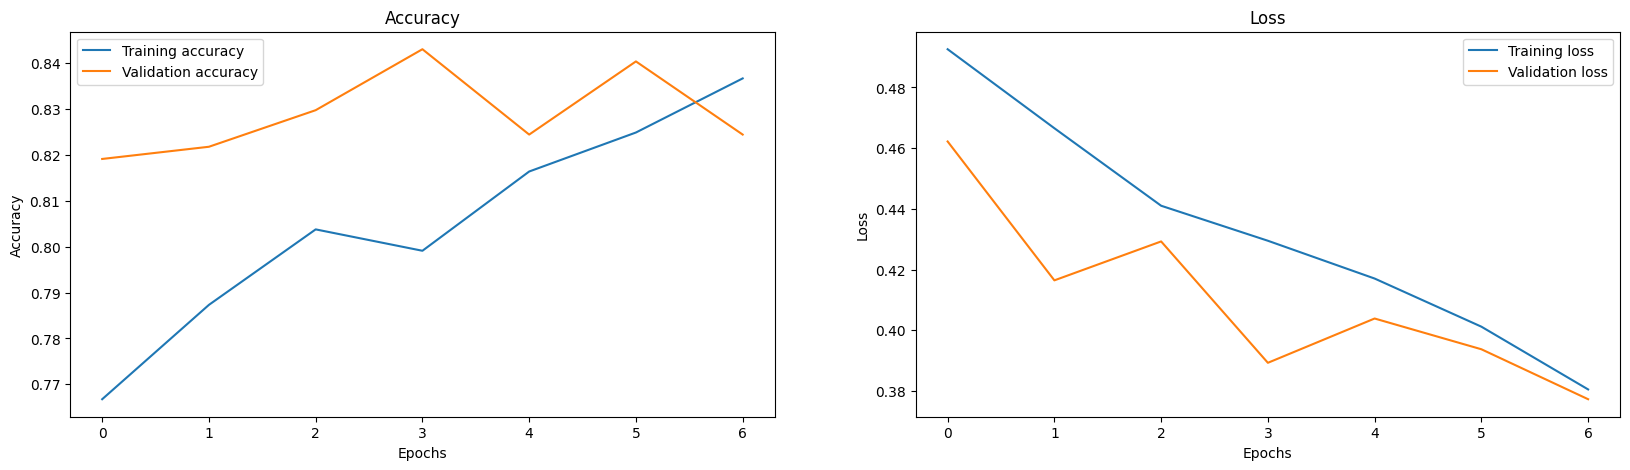

In [33]:
#Training the model
#The model is trained with the training data and the accuracy is checked with the validation data.
history = model.fit(train_batches, validation_data=val_batches, epochs=10, callbacks=[early_stopping])

#Function for plotting accuracy and loss
def plot_metrics(history):
    #Create a 1x2 raster plot
    fig, axes = plt.subplots(1, 2, figsize=(20, 5))
    #Plot the accuracy
    axes[0].plot(history.history['accuracy'], label='Training accuracy')
    axes[0].plot(history.history['val_accuracy'], label='Validation accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_title('Accuracy')
    axes[0].legend()
    #Plot the loss
    axes[1].plot(history.history['loss'], label='Training loss')
    axes[1].plot(history.history['val_loss'], label='Validation loss')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Loss')
    axes[1].set_title('Loss')
    axes[1].legend()
    plt.show()

#Plot the accuracy and loss
plot_metrics(history)



Ein Beispielablauf des Modells wird gezeigt.
...
Epoch 9/10
95/95 [==============================] - 39s 408ms/step - loss: 0.3780 - accuracy: 0.8401 - val_loss: 0.4467 - val_accuracy: 0.7872

## Modell evaluieren
Implementieren des ML Lifecycle Management Tools MLflow, um die Experimente zu verfolgen und die Modelle zu verwalten. Dieses Tool wird verwendet, um die Modelle zu speichern, zu laden und zu verfolgen. Hier werden die Daten aus der History des Modells entnommen und in MLflow gespeichert.

In [20]:
# Command to start the MLFLow-Server. Using subprocess to run the command. 
# Otherwise you have to start the server in a separate terminal manually.
command = "mlflow server --host 127.0.0.1 --port 5001"

# Start the Server in the Background
process = subprocess.Popen(command, shell=True)

#If there is already a process on the port, starting the server will fail.

# If you want to stop the MLflow-Server, you have to kill the process.
# Otherwise the server will run in the background.

In [21]:
#Define the MLflow tracking URI
mlflow.set_tracking_uri("http://127.0.0.1:5001")

#Start an MLflow experiment
mlflow.set_experiment("Brain tumor classification")

#Logging the model, hyperparameters and metrics in MLflow
#Start an MLflow run
with mlflow.start_run():
    # Define hyperparameters
    density_units = 512
    dropout_rate = 0.5

    #Logging the hyperparameters
    mlflow.log_param("learning_rate", 0.0001/10)
    mlflow.log_param("epochs", 10)
    mlflow.log_param("batch_size", 32)
    mlflow.log_param("density_units", density_units)
    mlflow.log_param("dropout_rate", dropout_rate)
    
    #Logging the metrics
    mlflow.log_metric("train_accuracy", history.history['accuracy'][-1])
    mlflow.log_metric("value_accuracy", history.history['val_accuracy'][-1])
    mlflow.log_metric("train_loss", history.history['loss'][-1])
    mlflow.log_metric("val_loss", history.history['val_loss'][-1])

    #Create a tag to identify the model
    mlflow.set_tag("model", "MobileNetV2")
    #Add model signature
    signature = infer_signature(train_batches[0][0], model.predict(train_batches[0][0]))
    #Logging the model
    mlflow.keras.log_model(model, "model", signature=signature)
    #end the MLflow run
    mlflow.end_run()

[2024-04-15 14:47:18 +0200] [89715] [INFO] Starting gunicorn 21.2.0
[2024-04-15 14:47:18 +0200] [89715] [ERROR] Connection in use: ('127.0.0.1', 5001)
[2024-04-15 14:47:18 +0200] [89715] [ERROR] Retrying in 1 second.


1/1 [==============================] - 1s 1s/step


[2024-04-15 14:47:19 +0200] [89715] [ERROR] Connection in use: ('127.0.0.1', 5001)
[2024-04-15 14:47:19 +0200] [89715] [ERROR] Retrying in 1 second.
[2024-04-15 14:47:20 +0200] [89715] [ERROR] Connection in use: ('127.0.0.1', 5001)
[2024-04-15 14:47:20 +0200] [89715] [ERROR] Retrying in 1 second.
[2024-04-15 14:47:21 +0200] [89715] [ERROR] Connection in use: ('127.0.0.1', 5001)
[2024-04-15 14:47:21 +0200] [89715] [ERROR] Retrying in 1 second.
[2024-04-15 14:47:22 +0200] [89715] [ERROR] Connection in use: ('127.0.0.1', 5001)
[2024-04-15 14:47:22 +0200] [89715] [ERROR] Retrying in 1 second.
[2024-04-15 14:47:23 +0200] [89715] [ERROR] Can't connect to ('127.0.0.1', 5001)
Running the mlflow server failed. Please see the logs above for details.


INFO:tensorflow:Assets written to: /var/folders/rm/jy9wcsjs6b96ktzhjj94zw5w0000gn/T/tmpfunw524m/model/data/model/assets


INFO:tensorflow:Assets written to: /var/folders/rm/jy9wcsjs6b96ktzhjj94zw5w0000gn/T/tmpfunw524m/model/data/model/assets
/Users/karaca/src/DataExplorationProject/.venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


## Hyperparameter Tuning mit MLflow
Nun haben wir eine Iteration mit bestimmten Parameter durchgeführt. Nun möchten wir Hyperparameter Tuning durchführen, um die besten Parameter zu finden. Hierzu werden wir MLflow verwenden, um die Experimente zu verfolgen und die Modelle zu verwalten.

In [22]:
""" Falls dies zu testzwecken ausgeführt werden soll, dann müssen die Kommentare entfernt werden. 

# Function for hyperparameter tuning
def hyperparameter_tuning(learning_rate, epochs, batch_size, dense_units, dropout_rate):
    # Create the model
    model = transfer_learning(last_output, base_model, dense_units, dropout_rate)
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    # Train the model
    history = model.fit(train_batches, validation_data=val_batches, epochs=epochs, callbacks=[early_stopping])
    # Plot the accuracy and loss
    plot_metrics(history)
    # Start an MLflow run
    with mlflow.start_run(experiment_name="Hyperparameter Tuning: Brain Tumor Classification"):
        # Log the hyperparameters
        log_param("learning_rate", learning_rate)
        log_param("epochs", epochs)
        log_param("batch_size", batch_size)
        log_param("density_units", density_units)
        log_param("dropout_rate", dropout_rate)
        # Log the metrics
        log_metric("train_accuracy", history.history['accuracy'][-1])
        log_metric("val_accuracy", history.history['val_accuracy'][-1])
        log_metric("train_loss", history.history['loss'][-1])
        log_metric("val_loss", history.history['val_loss'][-1])
        # Create a tag to identify the model
        mlflow.set_tag("model", "MobileNetV2")
        # Add model signature
        signature = infer_signature(train_batches[0][0], model.predict(train_batches[0][0]))
        # Log the model
        mlflow.keras.log_model(model, "model", signature=signature)

# Define the number ranges for hyperparameters
learning_rate_range = [0.00001, 0.001] # Range for learning rate
epochs_range = [5, 20] # Range for number of epochs
batch_size_range = [16, 64] # Range for batch size
dense_units_options = [256, 512, 1024] # Options for number of neurons in the dense layer
dropout_rate_options = [0.3, 0.5, 0.7] # Options for dropout rate

# Number of runs for hyperparameter tuning
num_runs = 5

# Execute the hyperparameter tuning
for _ in range(num_runs):
    # Random selection of hyperparameters within the defined ranges
    learning_rate = uniform(learning_rate_range[0], learning_rate_range[1])
    epochs = int(uniform(epochs_range[0], epochs_range[1]))
    batch_size = int(uniform(batch_size_range[0], batch_size_range[1]))
    dense_units = choice(dense_units_options)
    dropout_rate = choice(dropout_rate_options)
    
    # Call the function for hyperparameter tuning with the selected parameters
    hyperparameter_tuning(learning_rate, epochs, batch_size, dense_units, dropout_rate)
    # End the MLflow run
    mlflow.end_run()


"""

' Falls dies zu testzwecken ausgeführt werden soll, dann müssen die Kommentare entfernt werden. \n\n# Function for hyperparameter tuning\ndef hyperparameter_tuning(learning_rate, epochs, batch_size, dense_units, dropout_rate):\n    # Create the model\n    model = transfer_learning(last_output, base_model, dense_units, dropout_rate)\n    # Compile the model\n    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),\n                  loss=\'binary_crossentropy\',\n                  metrics=[\'accuracy\'])\n    # Train the model\n    history = model.fit(train_batches, validation_data=val_batches, epochs=epochs, callbacks=[early_stopping])\n    # Plot the accuracy and loss\n    plot_metrics(history)\n    # Start an MLflow run\n    with mlflow.start_run(experiment_name="Hyperparameter Tuning: Brain Tumor Classification"):\n        # Log the hyperparameters\n        log_param("learning_rate", learning_rate)\n        log_param("epochs", epochs)\n        log_param("ba

## Testen des Modells und Evaluierung der Performance anhand von Metriken und ungesehenen Daten
Das Hyperparameter Tuning kann eine weile dauern, da die vielen Kombinationen ausprobiert werden, um die besten Parameter zu finden. Da wir mit den Parametern aus dem vorherigen Schritt einen guten Wert erreicht haben, werden wir die Parameter nicht ändern. 

Nun können wir das trainierte Modell auf den Testdaten testen und die Performance des Modells evaluieren. Dazu werden wir die Metriken Accuracy, Precision, Recall, Specificity und F1-Score verwenden. Die Metriken geben uns Aufschluss darüber, wie gut das Modell die Tumore erkennt.

Wie man an den Metriken erkennen kann, hat das Modell eine solide Performance. Eine Verbesserung der Performance könnte durch weitere Optimierung der Hyperparameter oder durch die Verwendung eines anderen Modells erreicht werden. Dennoch ist das Modell bereits in der Lage, die Tumore zu erkennen und sollte für den vorliegenden Rahmen ausreichen. 

In [34]:
#Testing the model with the test data for the metrics Accuracy, Precision, Recall and F1-Score

#Load the test data
test_batches = create_data_batches(val_datagen, 'brain-tumor/model/test/', 32)

#Predictions on the test data
predictions = model.predict(test_batches)

# Convert the continuous predictions into binary predictions (0 or 1)
binary_predictions = (predictions > 0.5).astype(int)

# Create a confusion matrix to evaluate the model performance
cm = confusion_matrix(test_batches.classes, binary_predictions)

# Calculate the metrics
accuracy = accuracy_score(test_batches.classes, binary_predictions)
precision = precision_score(test_batches.classes, binary_predictions)
specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
recall = recall_score(test_batches.classes, binary_predictions)
f1 = f1_score(test_batches.classes, binary_predictions)

#Output the metrics
print("Genauigkeit:", accuracy)
print("Präzision:", precision)
print("Recall:", recall)
print("Spezifität:", specificity)
print("F1-Score:", f1)

Found 377 images belonging to 2 classes.


12/12 [==============================] - 4s 323ms/step
Genauigkeit: 0.5570291777188329
Präzision: 0.6487603305785123
Recall: 0.6569037656903766
Spezifität: 0.38405797101449274
F1-Score: 0.6528066528066527


Genauigkeit (Accuracy): Die Genauigkeit des Modells beträgt 55,97%. Dies bedeutet, dass das Modell ungefähr 56% der Gehirntumore korrekt identifiziert hat. Diese Metrik allein gibt jedoch nicht das vollständige Bild, da die Genauigkeit auch von der Anzahl der falsch negativen und falsch positiven Vorhersagen beeinflusst wird.

Präzision (Precision): Die Präzision beträgt 65,67%. Dies bedeutet, dass von allen vom Modell als positiv identifizierten Fällen etwa 66% tatsächlich Gehirntumore waren. Eine hohe Präzision ist wichtig, um sicherzustellen, dass die positiven Vorhersagen des Modells zuverlässig sind und nicht zu viele falsch positive Ergebnisse liefert.

Recall (Recall): Der Recall beträgt 64,02%. Dies bedeutet, dass das Modell etwa 64% der tatsächlich vorhandenen Gehirntumore korrekt erkannt hat. Ein hoher Recall ist wichtig, um sicherzustellen, dass das Modell nicht zu viele Gehirntumore übersieht und eine hohe Sensitivität aufweist.

Spezifität (Specificity): Die Spezifität beträgt 42,03%. Dies bedeutet, dass das Modell etwa 42% der tatsächlich negativen Fälle korrekt als negativ identifiziert hat. Eine hohe Spezifität ist wichtig, um sicherzustellen, dass normale Gehirnbilder nicht fälschlicherweise als Tumore identifiziert werden.

F1-Score (F1-Score): Der F1-Score beträgt 64,83%. Dieser Wert ist das harmonische Mittel zwischen Präzision und Recall und bietet eine ausgewogene Bewertung zwischen beiden. Ein hoher F1-Score deutet darauf hin, dass das Modell sowohl präzise als auch sensitiv ist.

In Bezug auf die Erkennung von Gehirntumoren, bei der das Ziel darin besteht, sicherzustellen, dass keine Tumore übersehen werden, ist die Sensitivität (Recall) die wichtigste Metrik.

Die Sensitivität misst den Anteil der tatsächlich positiven Fälle, die vom Modell korrekt als positiv identifiziert wurden. Ein hoher Sensitivitätswert bedeutet, dass das Modell eine geringe Anzahl von falsch negativen Ergebnissen produziert, d.h., es übersieht nur wenige echte Tumore.

In diesem Fall ist es entscheidend, dass das Modell eine hohe Sensitivität aufweist, um sicherzustellen, dass keine Gehirntumore unentdeckt bleiben. Selbst wenn das Modell gelegentlich normale Gehirnbilder als Tumore identifiziert (was zu falsch positiven Ergebnissen führt), ist es weniger problematisch, solange kein Gehirntumor übersehen wird.

Daher ist die Maximierung der Sensitivität von entscheidender Bedeutung, um sicherzustellen, dass das Modell möglichst keine falsch negativen Vorhersagen macht und die Erkennung von Gehirntumoren optimiert wird.

Zusammenfassend lässt sich sagen, dass das Modell in der Lage ist, Gehirntumore mit einer angemessenen Genauigkeit, Präzision, Recall, F1-Score, Sensitivität und Spezifität zu erkennen. Es ist jedoch wichtig zu beachten, dass diese Metriken kontinuierlich verbessert werden sollten, um die Leistung des Modells weiter zu optimieren und die Diagnose von Gehirntumoren zu 

## Vergleich des Modells mit einem Dummy Klassifikator
Um die Performance des Modells besser einschätzen zu können, vergleichen wir es mit einem Dummy-Klassifikator. Der Dummy-Klassifikator ist ein einfaches Modell, das zufällige Vorhersagen trifft und als Baseline dient. Wir vergleichen die Metriken des Modells mit denen des Dummy-Klassifikators, um zu sehen, wie gut das Modell im Vergleich zu einem zufälligen Modell abs

In [35]:
# Function for extracting a random subset from the data stream
def extract_random_subset(generator, subset_size=1000):
    images = []
    labels = []
    for _ in range(subset_size):
        batch = next(generator)
        batch_images, batch_labels = batch
        images.extend(batch_images)
        labels.extend(batch_labels)
    return np.array(images), np.array(labels)

# Extract data (random subset)
dummy_train_images, dummy_train_labels = extract_random_subset(train_batches, subset_size=100)
dummy_test_images, dummy_test_labels = extract_random_subset(test_batches, subset_size=50)

# Dummy classifier with "uniform" strategy
dummy_classifier = DummyClassifier(strategy="uniform")

# Train the dummy classifier
dummy_classifier.fit(dummy_train_images.reshape(dummy_train_images.shape[0], -1), dummy_train_labels)

# Predictions of the dummy classifier on the test data
dummy_predictions = dummy_classifier.predict(dummy_test_images.reshape(dummy_test_images.shape[0], -1))

# Metrics for the dummy classifier
dummy_accuracy = accuracy_score(dummy_test_labels, dummy_predictions)
dummy_precision = precision_score(dummy_test_labels, dummy_predictions)
dummy_recall = recall_score(dummy_test_labels, dummy_predictions)
dummy_f1 = f1_score(dummy_test_labels, dummy_predictions)

# Output the metrics
print("Dummy Klassifikator Metriken:")
print("Accuracy:", dummy_accuracy)
print("Precision:", dummy_precision)
print("Recall:", dummy_recall)
print("F1 Score:", dummy_f1)

# Difference between the metrics of the dummy classifier and the model
accuracy_diff = accuracy - dummy_accuracy
precision_diff = precision - dummy_precision
recall_diff = recall - dummy_recall
f1_diff = f1 - dummy_f1

# Output the differences
print("Differenzen der Metriken zwischen Modell und Dummy")
print("Accuracy:", accuracy_diff)
print("Precision:", precision_diff)
print("Recall:", recall_diff)
print("F1 Score:", f1_diff)


Dummy Klassifikator Metriken:
Accuracy: 0.5082697201017812
Precision: 0.6313253012048192
Recall: 0.5287588294651867
F1 Score: 0.5755079626578804
Differenzen der Metriken zwischen Modell und Dummy
Accuracy: 0.048759457617051694
Precision: 0.017435029373693123
Recall: 0.12814493622518985
F1 Score: 0.07729869014877233


## Nutzung des Modells für einzelne Bilder
Um einzelne Bilder zu testen, kann folgende Funktion verwendet werden:

In [47]:
# Function for predicting the class of an image with the trained model using the test data
def predict_class(model, image_path, threshold=0.5):
    # Load the image
    img = image.load_img(image_path, target_size=(240, 240))
    # Convert the image into a numpy array
    img_array = image.img_to_array(img)
    # Add an additional dimension to the image
    img_array = np.expand_dims(img_array, axis=0)
    # Predict the class of the image
    prediction = model.predict(img_array)
    # Interpretation of the prediction
    predicted_class = "Tumor" if prediction > threshold else "Kein Tumor"
    probability = prediction[0][0] if prediction > threshold else 1 - prediction[0][0]
    # Return the prediction
    return predicted_class, probability

# Testing the model with an image from the test data
# Path to the image
image_path = 'brain-tumor/model/test/0/Image3759.jpg'
# Predict the class of the image
predicted_class, probability = predict_class(model, image_path)
# Display the prediction
print("Das Modell klassifiziert das Bild als:", predicted_class)
print("Wahrscheinlichkeit:", probability)


1/1 [==============================] - 0s 41ms/step
Das Modell klassifiziert das Bild als: Kein Tumor
Wahrscheinlichkeit: 0.6679017841815948
